In [33]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [35]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [36]:
block_size = 3 # context length: how many characters do we take to predict the next one?

X, Y = [], []
for w in words:
    context = [0]*block_size
    for ch in w +'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)


In [37]:
# Creating 2 dimensional embedding matrix for all 27 characters

C = torch.randn((27, 10), requires_grad=True)

# Embedding whole input 

emd = C[X]

In [6]:
emd.shape

torch.Size([228146, 3, 10])

In [38]:
xs = torch.reshape(emd, (228146, 30))
xs.shape

torch.Size([228146, 30])

In [39]:
W1 = torch.randn((30, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)

In [40]:
h = torch.tanh((xs @ W1 + b1))  # Broadcasting happening here while summation with b1

In [10]:
h.shape

torch.Size([228146, 100])

In [41]:
# Creating final Layer (Softmax Layer)

W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

In [12]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [13]:
counts = logits.exp()
probs = counts/counts.sum(dim=1, keepdims=True)
probs.shape

torch.Size([228146, 27])

In [14]:
max(probs[0]), probs[0]

(tensor(0.6101, grad_fn=<UnbindBackward0>),
 tensor([2.4896e-12, 1.0317e-12, 1.8612e-05, 3.1598e-06, 6.3661e-04, 1.3233e-14,
         1.2190e-18, 1.3448e-09, 2.8572e-10, 6.1007e-01, 4.4999e-18, 1.7635e-08,
         2.2763e-14, 1.5013e-11, 7.3404e-14, 1.0219e-04, 3.6626e-01, 4.7236e-09,
         2.6740e-03, 2.5844e-17, 7.1784e-12, 9.6274e-17, 8.1756e-06, 3.1680e-14,
         3.1234e-12, 5.4951e-14, 2.0220e-02], grad_fn=<SelectBackward0>))

In [15]:
Y.shape, Y

(torch.Size([228146]), tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [16]:
# Probability Assigned to the all the actual Y values by the untrained model 

probs[torch.arange(X.shape[0]), Y]

tensor([1.3233e-14, 4.4427e-13, 1.3011e-07,  ..., 6.9608e-12, 3.5190e-08,
        9.6557e-09], grad_fn=<IndexBackward0>)

In [17]:
loss = probs[torch.arange(X.shape[0]), Y].log().sum()
loss = -1* loss/32
loss

tensor(139806.3906, grad_fn=<DivBackward0>)

In [18]:
F.cross_entropy(logits, Y) # Using cross_entropy is much more efficient than my own implementation of loss estimation (backward, forward efficiently)

tensor(19.6094, grad_fn=<NllLossBackward0>)

In [50]:
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

6097


In [43]:
# Putting all together
lossi = []
stepsi = []
for i in range(30000):
    # Forward Pass
    ix = torch.randint(0, X.shape[0], (32,)) # Randomly taking 32 samples from 22000 inputs, 32 x 3 x 2
    xs = torch.reshape(C[X[ix]], (32, 30))
    h = torch.tanh((xs @ W1 + b1))
    logits = h @ W2 + b2
    counts = logits.exp()
    probs = counts/counts.sum(dim=1, keepdims=True)
    
    # Loss
    loss = F.cross_entropy(logits, Y[ix])
    lossi.append(loss.item())
    stepsi.append(i)
    
    # Backward pass
    W1.grad = None
    b1.grad = None
    W2.grad = None
    b2.grad = None
    loss.backward()
    
    # Update Weights
    lr = 0.01
    C.data += -lr * C.grad
    W1.data += -lr * W1.grad
    b1.data += -lr * b1.grad
    W2.data += -lr * W2.grad
    b2.data += -lr * b2.grad
print(loss)

tensor(2.9508, grad_fn=<NllLossBackward0>)


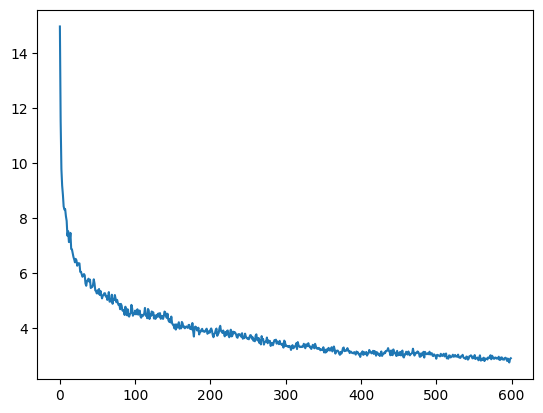

In [44]:
plt.plot(torch.tensor(lossi).view(-1, 50).mean(1))

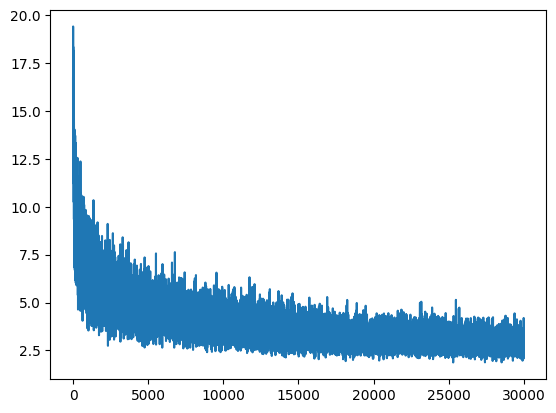

In [45]:
plt.plot(stepsi, lossi)

Sampling from the Model

In [21]:
xs = torch.reshape(X[3], (1, 3))
xs.shape

torch.Size([1, 3])

In [46]:
g = torch.Generator().manual_seed(123)

for _ in range(10):
    
    out = []
    context = [0] * 3 # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

lil.
mahai.
iuu.
borar.
jodendna.
coie.
syani.
ryi.
aveipeey.
tesa.
